# Chapter 10: Actor-Critic Methods

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adiel2012/reinforcement-learning/blob/main/notebooks/chapter10_actor_critic.ipynb)

This notebook implements actor-critic methods including A2C, A3C concepts, and Generalized Advantage Estimation (GAE).

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from tqdm import tqdm
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

## 10.1 Actor-Critic Architecture

Implement the basic actor-critic architecture with shared and separate networks.

In [27]:
class ActorCriticAgent:
    """Basic Actor-Critic agent"""

    def __init__(self, state_dim, action_dim, actor_lr=0.001, critic_lr=0.01,
                 gamma=0.99, shared_network=False):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.shared_network = shared_network

        if shared_network:
            # Shared feature extraction
            self.shared_layers = self._create_network([state_dim, 64, 64])
            # Actor head
            self.actor_head = self._create_network([64, action_dim])
            # Critic head
            self.critic_head = self._create_network([64, 1])
            self.actor_lr = actor_lr
            self.critic_lr = critic_lr
        else:
            # Separate networks
            self.actor = Actor(state_dim, action_dim, lr=actor_lr)
            self.critic = Critic(state_dim, lr=critic_lr)

        # Metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.actor_losses = []
        self.critic_losses = []
        self.advantages = []

    def _create_network(self, dims):
        """Create network layers"""
        layers = []
        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            layers.append({'weight': weight, 'bias': bias})
        return layers

    def _forward(self, x, layers, activation='relu'):
        """Forward pass through network"""
        activations = [x.reshape(1, -1) if len(x.shape) == 1 else x]

        for i, layer in enumerate(layers):
            z = np.dot(activations[-1], layer['weight']) + layer['bias']

            if i < len(layers) - 1:  # Hidden layers
                if activation == 'relu':
                    a = np.maximum(0, z)
                elif activation == 'tanh':
                    a = np.tanh(z)
            else:  # Output layer
                a = z  # Linear output

            activations.append(a)

        return activations

    def get_action_probs(self, state):
        """Get action probabilities from actor"""
        if self.shared_network:
            # Forward through shared layers
            shared_activations = self._forward(state, self.shared_layers)
            features = shared_activations[-1]

            # Forward through actor head
            actor_activations = self._forward(features, self.actor_head)
            logits = actor_activations[-1]
        else:
            logits = self.actor.forward(state)

        # Softmax
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / (np.sum(exp_logits) + 1e-8)
        return probs.flatten()

    def get_value(self, state):
        """Get state value from critic"""
        if self.shared_network:
            # Forward through shared layers
            shared_activations = self._forward(state, self.shared_layers)
            features = shared_activations[-1]

            # Forward through critic head
            critic_activations = self._forward(features, self.critic_head)
            value = critic_activations[-1]
        else:
            value = self.critic.forward(state)

        return value.item()

    def select_action(self, state):
        """Select action using policy"""
        probs = self.get_action_probs(state)
        action = np.random.choice(self.action_dim, p=probs)
        return action, probs[action]

    def train_step(self, state, action, reward, next_state, done):
        """Single step update"""
        # Get current and next values
        current_value = self.get_value(state)
        next_value = 0 if done else self.get_value(next_state)

        # TD error and advantage
        td_target = reward + self.gamma * next_value
        td_target = np.clip(td_target, -1000, 1000) # Clip target value
        td_error = td_target - current_value
        advantage = td_error

        self.advantages.append(advantage)

        # Update critic
        if self.shared_network:
            critic_loss = self._update_shared_critic(state, td_target)
        else:
            critic_loss = self.critic.update(state, td_target)

        self.critic_losses.append(critic_loss)

        # Update actor
        if self.shared_network:
            actor_loss = self._update_shared_actor(state, action, advantage)
        else:
            actor_loss = self.actor.update(state, action, advantage)

        self.actor_losses.append(actor_loss)

        return td_error, advantage

    def train_episode(self, env):
        """Train for one episode"""
        state = env.reset()
        episode_reward = 0
        steps = 0

        while True:
            action, _ = self.select_action(state)
            next_state, reward, done = env.step(action)

            # Update networks
            self.train_step(state, action, reward, next_state, done)

            episode_reward += reward
            steps += 1

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)

        return episode_reward, steps

class Actor:
    """Actor network"""

    def __init__(self, state_dim, action_dim, hidden_dims=[64, 64], lr=0.001):
        self.lr = lr

        # Initialize network
        self.layers = []
        dims = [state_dim] + hidden_dims + [action_dim]

        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            self.layers.append({'weight': weight, 'bias': bias})

    def forward(self, state):
        """Forward pass"""
        self.activations = [state.reshape(1, -1) if len(state.shape) == 1 else state]

        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['weight']) + layer['bias']

            if i < len(self.layers) - 1:  # Hidden layers
                a = np.maximum(0, z)  # ReLU
            else:  # Output layer
                a = z  # Linear output

            self.activations.append(a)

        return self.activations[-1]

    def update(self, state, action, advantage):
        """Update actor parameters"""
        # Forward pass
        logits = self.forward(state)

        # Softmax probabilities
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / (np.sum(exp_logits) + 1e-8)

        # Policy gradient
        grad_log_prob = np.zeros_like(probs)
        grad_log_prob[0, action] = 1.0 / (probs[0, action] + 1e-8)

        # Softmax gradient
        softmax_grad = np.zeros_like(probs)
        for i in range(probs.shape[1]):
            if i == action:
                softmax_grad[0, i] = probs[0, i] * (1 - probs[0, i])
            else:
                softmax_grad[0, i] = -probs[0, i] * probs[0, action]

        # Chain rule
        output_grad = grad_log_prob * softmax_grad * advantage

        # Backpropagate
        delta = output_grad

        for i in range(len(self.layers) - 1, -1, -1):
            # Gradient clipping
            grad_w = np.dot(self.activations[i].T, delta)
            grad_b = np.sum(delta, axis=0)
            grad_w = np.clip(grad_w, -1, 1)
            grad_b = np.clip(grad_b, -1, 1)

            # Update weights
            self.layers[i]['weight'] += self.lr * grad_w
            self.layers[i]['bias'] += self.lr * grad_b

            if i > 0:
                # Compute delta for previous layer
                delta = np.dot(delta, self.layers[i]['weight'].T)
                delta *= (self.activations[i] > 0).astype(float)

        # Return loss for monitoring
        return -np.log(probs[0, action] + 1e-8) * advantage

class Critic:
    """Critic network"""

    def __init__(self, state_dim, hidden_dims=[64, 64], lr=0.01):
        self.lr = lr

        # Initialize network
        self.layers = []
        dims = [state_dim] + hidden_dims + [1]

        for i in range(len(dims) - 1):
            weight = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2.0 / dims[i])
            bias = np.zeros(dims[i+1])
            self.layers.append({'weight': weight, 'bias': bias})

    def forward(self, state):
        """Forward pass"""
        self.activations = [state.reshape(1, -1) if len(state.shape) == 1 else state]

        for i, layer in enumerate(self.layers):
            z = np.dot(self.activations[-1], layer['weight']) + layer['bias']

            if i < len(self.layers) - 1:  # Hidden layers
                a = np.maximum(0, z)  # ReLU
            else:  # Output layer
                a = z  # Linear output

            self.activations.append(a)

        return self.activations[-1]

    def update(self, state, target):
        """Update critic parameters"""
        # Forward pass
        prediction = self.forward(state)
        error = target - prediction.item()
        error = np.clip(error, -1, 1) # Clip error

        # Backpropagate
        delta = np.array([[error]])

        for i in range(len(self.layers) - 1, -1, -1):
            # Gradient clipping
            grad_w = np.dot(self.activations[i].T, delta)
            grad_b = np.sum(delta, axis=0)
            grad_w = np.clip(grad_w, -1, 1)
            grad_b = np.clip(grad_b, -1, 1)

            # Update weights
            self.layers[i]['weight'] += self.lr * grad_w
            self.layers[i]['bias'] += self.lr * grad_b

            if i > 0:
                # Compute delta for previous layer
                delta = np.dot(delta, self.layers[i]['weight'].T)
                delta *= (self.activations[i] > 0).astype(float)

        return error ** 2

print("Actor-Critic components implemented")

Actor-Critic components implemented


## 10.2 A2C (Advantage Actor-Critic)

Implement A2C with batch updates and entropy regularization.

In [28]:
class A2CAgent:
    """Advantage Actor-Critic (A2C) agent"""

    def __init__(self, state_dim, action_dim, actor_lr=0.001, critic_lr=0.01,
                 gamma=0.99, entropy_coef=0.01, value_coef=0.5, n_steps=5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.n_steps = n_steps

        # Networks
        self.actor = Actor(state_dim, action_dim, lr=actor_lr)
        self.critic = Critic(state_dim, lr=critic_lr)

        # Metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_losses = []
        self.value_losses = []
        self.entropy_losses = []
        self.advantages_history = []

    def compute_returns_and_advantages(self, rewards, values, dones):
        """Compute n-step returns and advantages"""
        returns = []
        advantages = []

        # Bootstrap from last value if not done
        if not dones[-1]:
            bootstrap_value = values[-1]
        else:
            bootstrap_value = 0

        # Compute returns
        R = bootstrap_value
        for i in reversed(range(len(rewards))):
            if dones[i]:
                R = 0
            R = rewards[i] + self.gamma * R
            returns.insert(0, R)

        # Compute advantages
        for i in range(len(returns)):
            advantage = returns[i] - values[i]
            advantages.append(advantage)

        return np.array(returns), np.array(advantages)

    def update_networks(self, states, actions, returns, advantages):
        """Update actor and critic networks"""
        # Normalize advantages
        if len(advantages) > 1:
            advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Update critic
        value_loss = 0
        for state, target in zip(states, returns):
            loss = self.critic.update(state, target)
            value_loss += loss

        value_loss /= len(states)
        self.value_losses.append(value_loss)

        # Update actor
        policy_loss = 0
        entropy_loss = 0

        for state, action, advantage in zip(states, actions, advantages):
            # Get action probabilities
            logits = self.actor.forward(state)
            probs = np.exp(logits - np.max(logits))
            probs = probs / np.sum(probs)

            # Policy loss
            log_prob = np.log(probs[0, action] + 1e-8)
            policy_loss -= log_prob * advantage

            # Entropy loss (for exploration)
            entropy = -np.sum(probs * np.log(probs + 1e-8))
            entropy_loss -= entropy

            # Update actor
            self.actor.update(state, action, advantage)

        policy_loss /= len(states)
        entropy_loss /= len(states)

        self.policy_losses.append(policy_loss)
        self.entropy_losses.append(entropy_loss)
        self.advantages_history.extend(advantages)

        return policy_loss, value_loss, entropy_loss

    def train_episode(self, env):
        """Train for one episode using n-step updates"""
        state = env.reset()
        episode_reward = 0
        steps = 0

        # Buffers for n-step updates
        states_buffer = []
        actions_buffer = []
        rewards_buffer = []
        values_buffer = []
        dones_buffer = []

        while True:
            # Get action and value
            action_probs = self.actor.forward(state)
            probs = np.exp(action_probs - np.max(action_probs))
            probs = probs / np.sum(probs)
            action = np.random.choice(self.action_dim, p=probs.flatten())

            value = self.critic.forward(state).item()

            # Store in buffers
            states_buffer.append(state.copy())
            actions_buffer.append(action)
            values_buffer.append(value)

            # Take action
            next_state, reward, done = env.step(action)

            rewards_buffer.append(reward)
            dones_buffer.append(done)

            episode_reward += reward
            steps += 1

            # Update networks every n_steps or at episode end
            if len(states_buffer) == self.n_steps or done:
                # Add final value for bootstrapping
                if not done:
                    final_value = self.critic.forward(next_state).item()
                    values_buffer.append(final_value)
                    dones_buffer.append(False)

                # Compute returns and advantages
                returns, advantages = self.compute_returns_and_advantages(
                    rewards_buffer, values_buffer[:-1] if not done else values_buffer,
                    dones_buffer[:-1] if not done else dones_buffer
                )

                # Update networks
                self.update_networks(states_buffer, actions_buffer, returns, advantages)

                # Clear buffers
                states_buffer = []
                actions_buffer = []
                rewards_buffer = []
                values_buffer = []
                dones_buffer = []

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)

        return episode_reward, steps

print("A2C Agent implemented")

A2C Agent implemented


## 10.3 Generalized Advantage Estimation (GAE)

Implement GAE for better advantage estimation.

In [29]:
class GAEAgent:
    """Actor-Critic with Generalized Advantage Estimation"""

    def __init__(self, state_dim, action_dim, actor_lr=0.001, critic_lr=0.01,
                 gamma=0.99, lambda_gae=0.95, entropy_coef=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lambda_gae = lambda_gae
        self.entropy_coef = entropy_coef

        # Networks
        self.actor = Actor(state_dim, action_dim, lr=actor_lr)
        self.critic = Critic(state_dim, lr=critic_lr)

        # Metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.policy_losses = []
        self.value_losses = []
        self.gae_advantages = []

    def compute_gae(self, rewards, values, dones, next_value=0):
        """Compute Generalized Advantage Estimation"""
        advantages = []
        gae = 0

        # Add next_value for bootstrapping
        values = values + [next_value]

        # Compute GAE backwards
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_non_terminal = 1.0 - dones[t]
                next_value = values[t + 1]
            else:
                next_non_terminal = 1.0 - dones[t]
                next_value = values[t + 1]

            # TD error
            delta = rewards[t] + self.gamma * next_value * next_non_terminal - values[t]

            # GAE
            gae = delta + self.gamma * self.lambda_gae * next_non_terminal * gae
            advantages.insert(0, gae)

        # Compute returns
        returns = [adv + val for adv, val in zip(advantages, values[:-1])]

        return np.array(advantages), np.array(returns)

    def train_episode(self, env, update_freq=32):
        """Train for one episode with GAE"""
        state = env.reset()
        episode_reward = 0
        steps = 0

        # Episode buffers
        states = []
        actions = []
        rewards = []
        values = []
        dones = []

        step_count = 0

        while True:
            # Get action and value
            action_logits = self.actor.forward(state)
            probs = np.exp(action_logits - np.max(action_logits))
            probs = probs / np.sum(probs)
            action = np.random.choice(self.action_dim, p=probs.flatten())

            value = self.critic.forward(state).item()

            # Store experience
            states.append(state.copy())
            actions.append(action)
            values.append(value)

            # Take action
            next_state, reward, done = env.step(action)

            rewards.append(reward)
            dones.append(done)

            episode_reward += reward
            steps += 1
            step_count += 1

            # Update networks periodically or at episode end
            if step_count >= update_freq or done:
                # Get next value for bootstrapping
                if not done:
                    next_value = self.critic.forward(next_state).item()
                else:
                    next_value = 0

                # Compute GAE advantages and returns
                advantages, returns = self.compute_gae(rewards, values, dones, next_value)

                # Normalize advantages
                if len(advantages) > 1:
                    advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

                self.gae_advantages.extend(advantages)

                # Update networks
                policy_loss = 0
                value_loss = 0

                for i in range(len(states)):
                    # Update critic
                    v_loss = self.critic.update(states[i], returns[i])
                    value_loss += v_loss

                    # Update actor
                    p_loss = self.actor.update(states[i], actions[i], advantages[i])
                    policy_loss += abs(p_loss)

                self.policy_losses.append(policy_loss / len(states))
                self.value_losses.append(value_loss / len(states))

                # Clear buffers
                states = []
                actions = []
                rewards = []
                values = []
                dones = []
                step_count = 0

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)

        return episode_reward, steps

print("GAE Agent implemented")

GAE Agent implemented


## 10.4 Training and Comparison

Train and compare different actor-critic variants.

In [25]:
# CartPole environment
class CartPole:
    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4
        self.state = None
        self.steps = 0

    def reset(self):
        self.state = np.random.uniform(-0.05, 0.05, 4)
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = np.array([x, x_dot, theta, theta_dot])
        self.steps += 1

        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians or
            self.steps >= 500
        )

        reward = 1.0 if not done else 0.0
        return self.state.copy(), reward, done

# Train different actor-critic agents
env = CartPole()
state_dim, action_dim = 4, 2
training_episodes = 800

agents = {
    'Actor-Critic': ActorCriticAgent(state_dim, action_dim, actor_lr=0.0001, critic_lr=0.001),
    'A2C': A2CAgent(state_dim, action_dim, actor_lr=0.0001, critic_lr=0.001, n_steps=5),
    'AC + GAE': GAEAgent(state_dim, action_dim, actor_lr=0.0001, critic_lr=0.001, lambda_gae=0.95)
}

print("Training Actor-Critic variants...")
for name, agent in agents.items():
    print(f"\nTraining {name}...")

    for episode in tqdm(range(training_episodes), desc=name):
        env = CartPole()  # Fresh environment
        agent.train_episode(env)

        if episode % 200 == 0 and episode > 0:
            avg_reward = np.mean(agent.episode_rewards[-100:])
            print(f"  Episode {episode}: avg_reward={avg_reward:.1f}")

    final_avg = np.mean(agent.episode_rewards[-100:])
    print(f"Final performance: {final_avg:.1f}")

print("Training completed!")

Training Actor-Critic variants...

Training Actor-Critic...


Actor-Critic:  28%|██▊       | 228/800 [00:01<00:03, 184.31it/s]

  Episode 200: avg_reward=9.8


Actor-Critic:  55%|█████▍    | 438/800 [00:02<00:01, 228.23it/s]

  Episode 400: avg_reward=8.5


Actor-Critic:  80%|███████▉  | 639/800 [00:03<00:00, 248.36it/s]

  Episode 600: avg_reward=8.2


Actor-Critic: 100%|██████████| 800/800 [00:03<00:00, 209.49it/s]


Final performance: 8.5

Training A2C...


A2C:  29%|██▉       | 231/800 [00:01<00:03, 173.67it/s]

  Episode 200: avg_reward=11.3


A2C:  55%|█████▍    | 436/800 [00:02<00:02, 177.60it/s]

  Episode 400: avg_reward=11.6


A2C:  78%|███████▊  | 621/800 [00:03<00:01, 175.96it/s]

  Episode 600: avg_reward=11.5


A2C: 100%|██████████| 800/800 [00:04<00:00, 164.71it/s]


Final performance: 13.3

Training AC + GAE...


AC + GAE:  26%|██▌       | 208/800 [00:04<00:13, 44.38it/s]

  Episode 200: avg_reward=39.3


AC + GAE:  51%|█████     | 407/800 [00:08<00:07, 51.33it/s]

  Episode 400: avg_reward=46.9


AC + GAE:  76%|███████▌  | 607/800 [00:12<00:05, 37.37it/s]

  Episode 600: avg_reward=55.7


AC + GAE: 100%|██████████| 800/800 [00:18<00:00, 42.24it/s]

Final performance: 77.3
Training completed!


## 10.5 Performance Analysis

Analyze and compare the performance of different actor-critic methods.

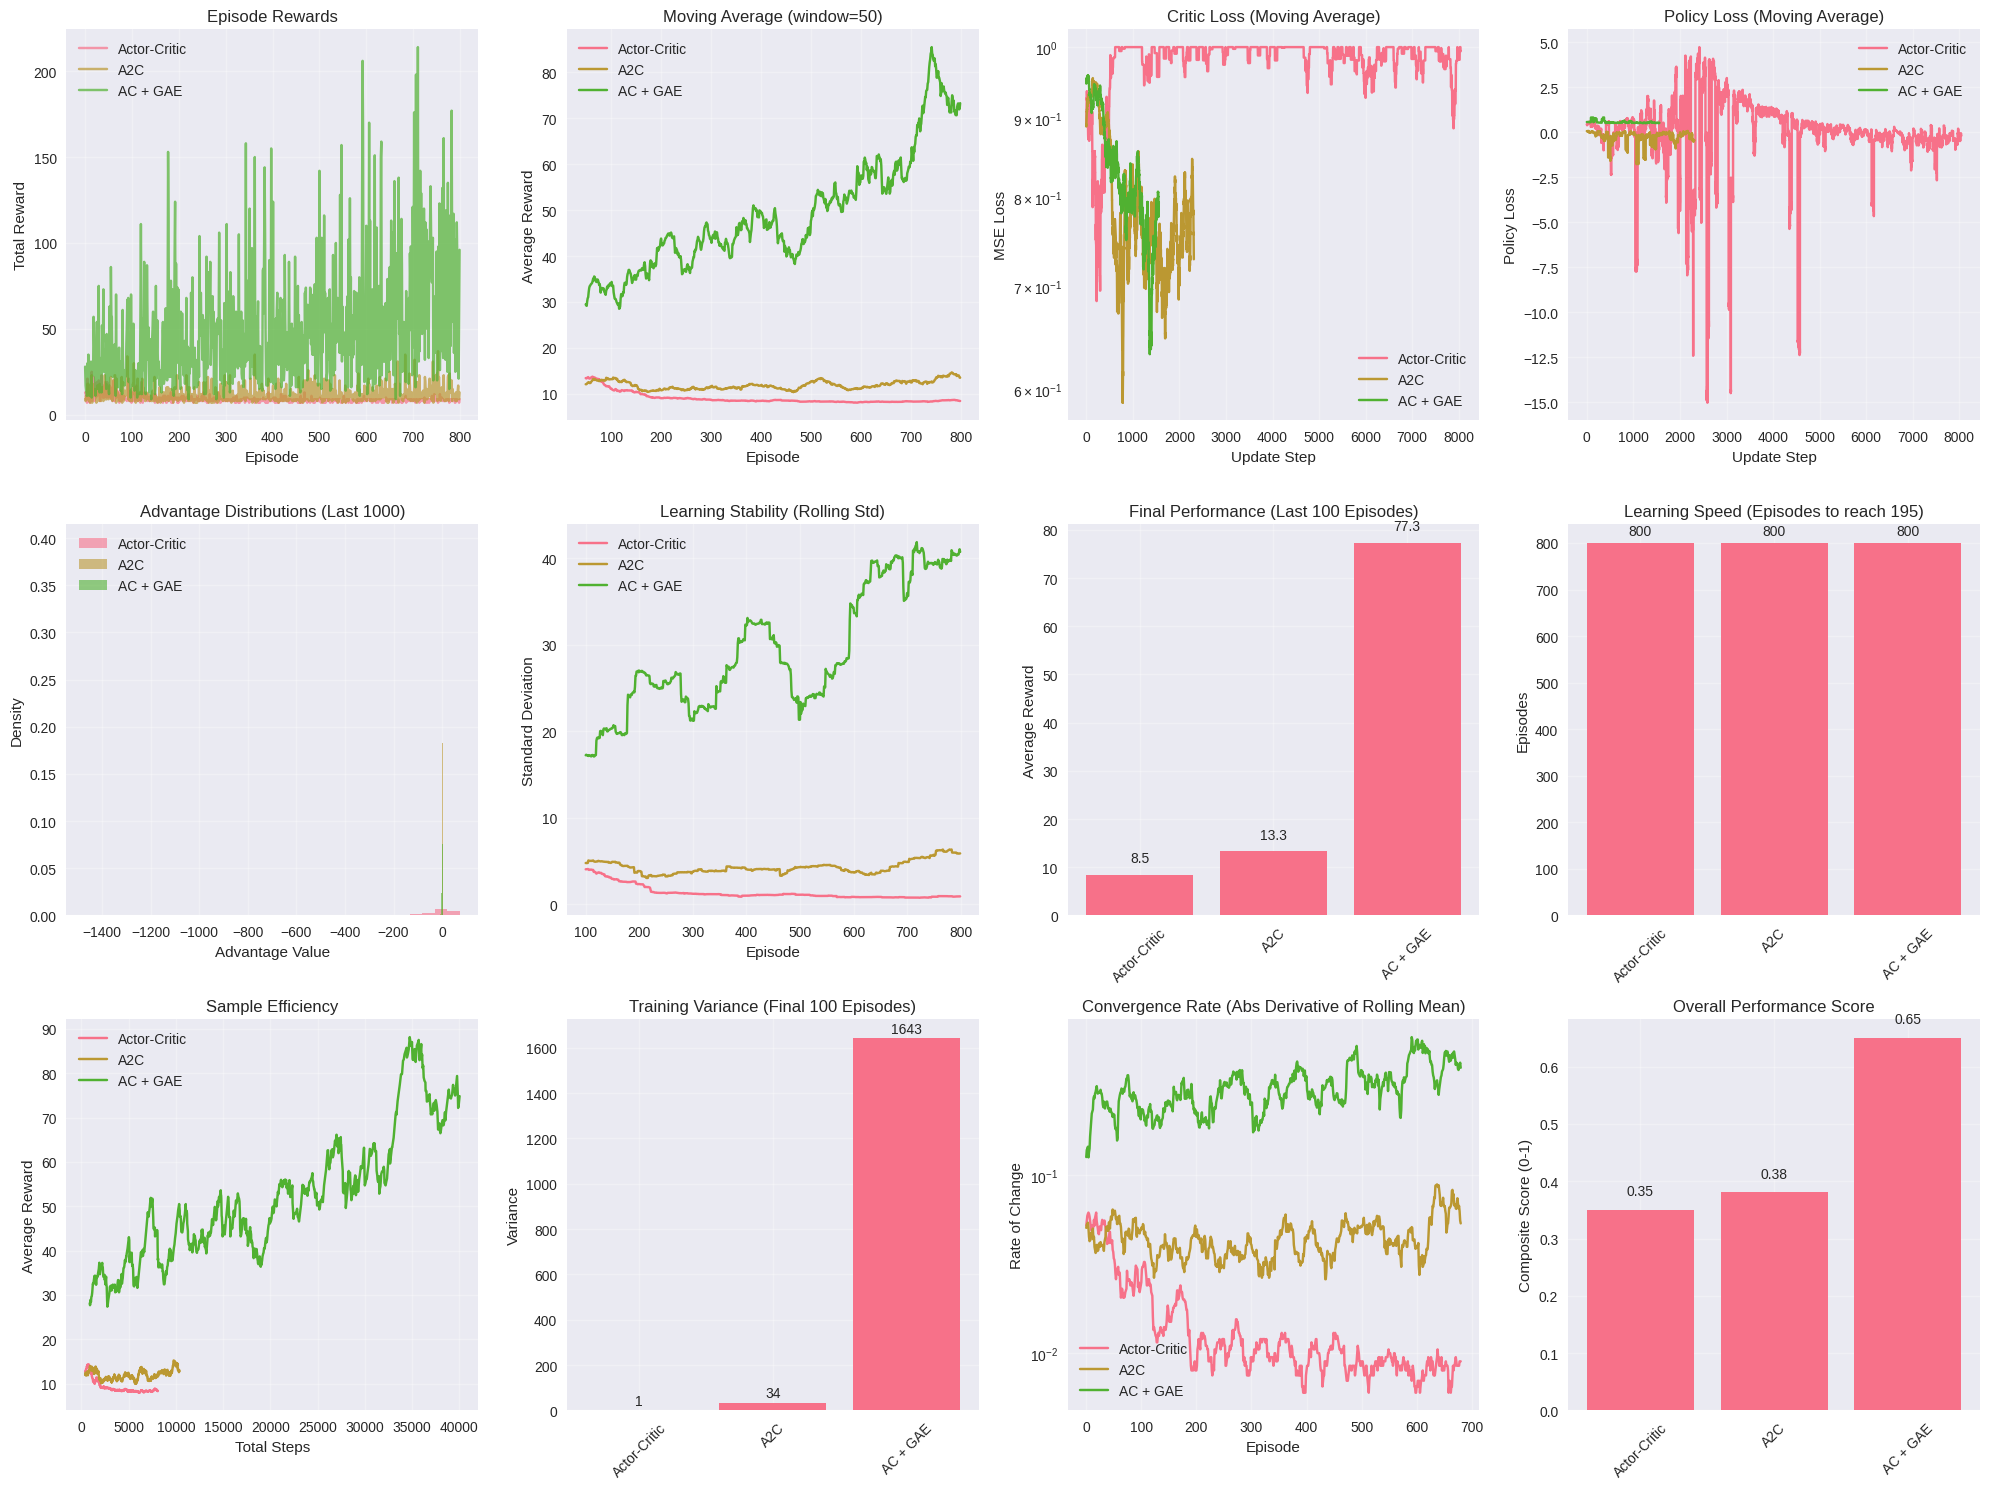


ACTOR-CRITIC METHODS COMPARISON
Method          Final Perf   Speed      Variance     Composite 
--------------------------------------------------------------------------------
Actor-Critic    8.5          800        0.8          0.350     
A2C             13.3         800        34.3         0.381     
AC + GAE        77.3         800        1643.5       0.650     

Best overall method: AC + GAE (score: 0.650)


In [30]:
# Performance analysis
plt.figure(figsize=(20, 15))

# Episode rewards
plt.subplot(3, 4, 1)
for name, agent in agents.items():
    plt.plot(agent.episode_rewards, label=name, alpha=0.7)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Moving averages
plt.subplot(3, 4, 2)
window = 50
for name, agent in agents.items():
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(agent.episode_rewards)), moving_avg, label=name)
plt.title(f'Moving Average (window={window})')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Value losses
plt.subplot(3, 4, 3)
for name, agent in agents.items():
    if hasattr(agent, 'value_losses') and len(agent.value_losses) > 0:
        loss_window = 50
        if len(agent.value_losses) >= loss_window:
            loss_avg = np.convolve(agent.value_losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
    elif hasattr(agent, 'critic_losses') and len(agent.critic_losses) > 0:
        loss_window = 50
        if len(agent.critic_losses) >= loss_window:
            loss_avg = np.convolve(agent.critic_losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
plt.title('Critic Loss (Moving Average)')
plt.xlabel('Update Step')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Policy losses
plt.subplot(3, 4, 4)
for name, agent in agents.items():
    if hasattr(agent, 'policy_losses') and len(agent.policy_losses) > 0:
        loss_window = 50
        if len(agent.policy_losses) >= loss_window:
            loss_avg = np.convolve(agent.policy_losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
    elif hasattr(agent, 'actor_losses') and len(agent.actor_losses) > 0:
        loss_window = 50
        if len(agent.actor_losses) >= loss_window:
            loss_avg = np.convolve(agent.actor_losses, np.ones(loss_window)/loss_window, mode='valid')
            plt.plot(loss_avg, label=name)
plt.title('Policy Loss (Moving Average)')
plt.xlabel('Update Step')
plt.ylabel('Policy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Advantage distributions
plt.subplot(3, 4, 5)
for name, agent in agents.items():
    if hasattr(agent, 'advantages') and len(agent.advantages) > 0:
        advantages = agent.advantages[-1000:]  # Last 1000 advantages
        plt.hist(advantages, bins=30, alpha=0.6, label=name, density=True)
    elif hasattr(agent, 'gae_advantages') and len(agent.gae_advantages) > 0:
        advantages = agent.gae_advantages[-1000:]  # Last 1000 advantages
        plt.hist(advantages, bins=30, alpha=0.6, label=name, density=True)
    elif hasattr(agent, 'advantages_history') and len(agent.advantages_history) > 0:
        advantages = agent.advantages_history[-1000:]  # Last 1000 advantages
        plt.hist(advantages, bins=30, alpha=0.6, label=name, density=True)

plt.title('Advantage Distributions (Last 1000)')
plt.xlabel('Advantage Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning stability (rolling standard deviation)
plt.subplot(3, 4, 6)
stability_window = 100
for name, agent in agents.items():
    if len(agent.episode_rewards) >= stability_window:
        rolling_std = []
        for i in range(stability_window, len(agent.episode_rewards)):
            std = np.std(agent.episode_rewards[i-stability_window:i])
            rolling_std.append(std)
        plt.plot(range(stability_window, len(agent.episode_rewards)), rolling_std, label=name)

plt.title('Learning Stability (Rolling Std)')
plt.xlabel('Episode')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance comparison
plt.subplot(3, 4, 7)
final_performances = []
names = []
for name, agent in agents.items():
    final_avg = np.mean(agent.episode_rewards[-100:])
    final_performances.append(final_avg)
    names.append(name)

bars = plt.bar(names, final_performances)
plt.title('Final Performance (Last 100 Episodes)')
plt.ylabel('Average Reward')
plt.xticks(rotation=45)

for bar, value in zip(bars, final_performances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value:.1f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Learning speed
plt.subplot(3, 4, 8)
solve_threshold = 195
learning_speeds = []

for name, agent in agents.items():
    window = 50
    if len(agent.episode_rewards) >= window:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        solved_episodes = np.where(moving_avg >= solve_threshold)[0]
        if len(solved_episodes) > 0:
            learning_speed = solved_episodes[0] + window - 1
        else:
            learning_speed = len(agent.episode_rewards)
    else:
        learning_speed = len(agent.episode_rewards)

    learning_speeds.append(learning_speed)

bars = plt.bar(names, learning_speeds)
plt.title(f'Learning Speed (Episodes to reach {solve_threshold})')
plt.ylabel('Episodes')
plt.xticks(rotation=45)

for bar, value in zip(bars, learning_speeds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{value}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Sample efficiency
plt.subplot(3, 4, 9)
for name, agent in agents.items():
    cumulative_steps = np.cumsum(agent.episode_lengths)
    window = 30
    if len(agent.episode_rewards) >= window:
        moving_avg_rewards = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        cumulative_steps_windowed = cumulative_steps[window-1:]
        plt.plot(cumulative_steps_windowed, moving_avg_rewards, label=name)

plt.title('Sample Efficiency')
plt.xlabel('Total Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True, alpha=0.3)

# Variance analysis
plt.subplot(3, 4, 10)
variances = []
for name, agent in agents.items():
    final_variance = np.var(agent.episode_rewards[-100:])
    variances.append(final_variance)

bars = plt.bar(names, variances)
plt.title('Training Variance (Final 100 Episodes)')
plt.ylabel('Variance')
plt.xticks(rotation=45)

for bar, value in zip(bars, variances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{value:.0f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(3, 4, 11)
for name, agent in agents.items():
    # Compute rolling mean and check when it stabilizes
    window = 100
    if len(agent.episode_rewards) >= window:
        rolling_mean = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
        # Derivative to see convergence
        derivative = np.diff(rolling_mean)
        abs_derivative = np.abs(derivative)
        smooth_derivative = np.convolve(abs_derivative, np.ones(20)/20, mode='valid')
        plt.plot(smooth_derivative, label=name)

plt.title('Convergence Rate (Abs Derivative of Rolling Mean)')
plt.xlabel('Episode')
plt.ylabel('Rate of Change')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Overall score
plt.subplot(3, 4, 12)
# Compute composite scores
norm_performance = [(p - min(final_performances)) / (max(final_performances) - min(final_performances))
                   for p in final_performances] if max(final_performances) > min(final_performances) else [0.5] * len(final_performances)
norm_speed = [(max(learning_speeds) - s) / (max(learning_speeds) - min(learning_speeds))
             for s in learning_speeds] if max(learning_speeds) > min(learning_speeds) else [0.5] * len(learning_speeds)
norm_stability = [(max(variances) - v) / (max(variances) - min(variances))
                 for v in variances] if max(variances) > min(variances) else [0.5] * len(variances)

composite_scores = [0.5*p + 0.3*s + 0.2*st for p, s, st in zip(norm_performance, norm_speed, norm_stability)]

bars = plt.bar(names, composite_scores)
plt.title('Overall Performance Score')
plt.ylabel('Composite Score (0-1)')
plt.xticks(rotation=45)

for bar, score in zip(bars, composite_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.2f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("ACTOR-CRITIC METHODS COMPARISON")
print("="*80)
print(f"{'Method':<15} {'Final Perf':<12} {'Speed':<10} {'Variance':<12} {'Composite':<10}")
print("-"*80)

for i, name in enumerate(names):
    print(f"{name:<15} {final_performances[i]:<12.1f} {learning_speeds[i]:<10} {variances[i]:<12.1f} {composite_scores[i]:<10.3f}")

best_idx = np.argmax(composite_scores)
print(f"\nBest overall method: {names[best_idx]} (score: {composite_scores[best_idx]:.3f})")
print("="*80)

## 🎯 Chapter 10 Summary

This notebook demonstrated actor-critic methods and their key advantages:

### Key Methods Implemented:

1. **Basic Actor-Critic**:
   - Online policy and value function updates
   - Single-step TD learning
   - Lower variance than REINFORCE

2. **Advantage Actor-Critic (A2C)**:
   - Batch updates with n-step returns
   - Entropy regularization for exploration
   - More stable training

3. **GAE (Generalized Advantage Estimation)**:
   - Exponentially weighted advantage estimation
   - Bias-variance tradeoff control via λ parameter
   - Improved advantage estimation

### Key Insights:

- **Actor-critic** combines benefits of value-based and policy-based methods
- **Critic** provides lower-variance baselines than Monte Carlo
- **Batch updates** (A2C) are more stable than online updates
- **GAE** provides better advantage estimates with controllable bias-variance
- **Entropy regularization** prevents premature convergence

### Advantages of Actor-Critic:

1. **Lower variance** than pure policy gradients
2. **Online learning** (can update during episode)
3. **Continuous actions** naturally handled
4. **Faster convergence** than REINFORCE
5. **More sample efficient** than Monte Carlo methods

### Design Choices:

- **Shared vs separate networks**: Trade-off between parameter sharing and specialization
- **Update frequency**: Online vs batch updates
- **Advantage estimation**: TD vs GAE vs n-step
- **Exploration**: Entropy regularization vs ε-greedy

### Best Practices:

- **Use GAE** for better advantage estimation
- **Add entropy regularization** to maintain exploration
- **Normalize advantages** for stable training
- **Tune critic learning rate** carefully
- **Consider shared networks** for parameter efficiency

### Next Steps:
- Chapter 11: Advanced Policy Optimization (TRPO, PPO)
- Implement asynchronous methods (A3C)
- Try continuous control problems
- Explore different network architectures

---
*This notebook is part of the Reinforcement Learning for Engineer-Mathematicians textbook.*